<span style="font-size:30px;">Packages</span>

In [1]:
from dask.distributed import Client
from glob import glob
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import numpy as np

<span style="font-size:30px;">Read data</span>

In [2]:
flist_control=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/10min/psl/psl_AUS2200_flood22-coralsea-control_subhrPt_2022*.nc'))
flist_exp=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstreduced/v1-0/10min/psl/psl_AUS2200_flood22-reducedsst_subhrPt_2022*.nc'))
flist_control_u=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/1hrPlev/ua/ua_AUS2200_flood22-coralsea-control_1hrPt_2022*.nc'))
flist_control_v=sorted(glob('/g/data/bs94/AUS2200/coralsea-sstobs/v1-0/1hrPlev/va/va_AUS2200_flood22-coralsea-control_1hrPt_2022*.nc'))

In [3]:
client=Client()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32961 instead
  warnings.warn(


<span style="font-size:30px;">Analysis</span>

In [4]:
ds_control = xr.open_mfdataset(flist_control,parallel=True,preprocess=lambda x: x['psl'])
ds_exp = xr.open_mfdataset(flist_exp,parallel=True,preprocess=lambda x: x['psl'])
ds_control_u = xr.open_mfdataset(flist_control_u,parallel=True,preprocess=lambda x: x['ua'])
ds_control_v = xr.open_mfdataset(flist_control_v,parallel=True,preprocess=lambda x: x['va'])

In [5]:
da_fin_control=ds_control.resample(time='1D',offset='23h').mean()
da_fin_exp=ds_exp.resample(time='1D',offset='23h').mean()
da_fin_control_u = ds_control_u.resample(time='1D',offset='23h').mean()
da_fin_control_v = ds_control_v.resample(time='1D',offset='23h').mean()

In [6]:
mslp_control=da_fin_control['psl']
mslp_exp=da_fin_exp['psl']
control_u = da_fin_control_u['ua']
control_v = da_fin_control_v['va']

In [7]:
control_u850 = control_u.sel(plev='85000', time=slice('2022-02-24T23:00:00.000000000','2022-03-02T23:00:00.000000000'), lat=slice(-44,-10), lon=slice(143,159))/10
control_v850 = control_v.sel(plev='85000', time=slice('2022-02-24T23:00:00.000000000','2022-03-02T23:00:00.000000000'), lat=slice(-44,-10), lon=slice(143,159))/10
control_mslp = mslp_control.sel(time=slice('2022-02-24T23:00:00.000000000','2022-03-02T23:00:00.000000000'), lat=slice(-44,-10), lon=slice(143,159))/100
exp_mslp = mslp_exp.sel(time=slice('2022-02-24T23:00:00.000000000','2022-03-02T23:00:00.000000000'), lat=slice(-44,-10), lon=slice(143,159))/100
mslp_cont_minus_exp = control_mslp - exp_mslp

In [8]:
lat = control_u850.lat.loc[:]
lon = control_u850.lon.loc[:]
latm = control_mslp.lat.loc[:]
lonm = control_mslp.lon.loc[:]

<span style="font-size:30px;">Plots</span>

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contour(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contourf(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1601: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contour(*args, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python

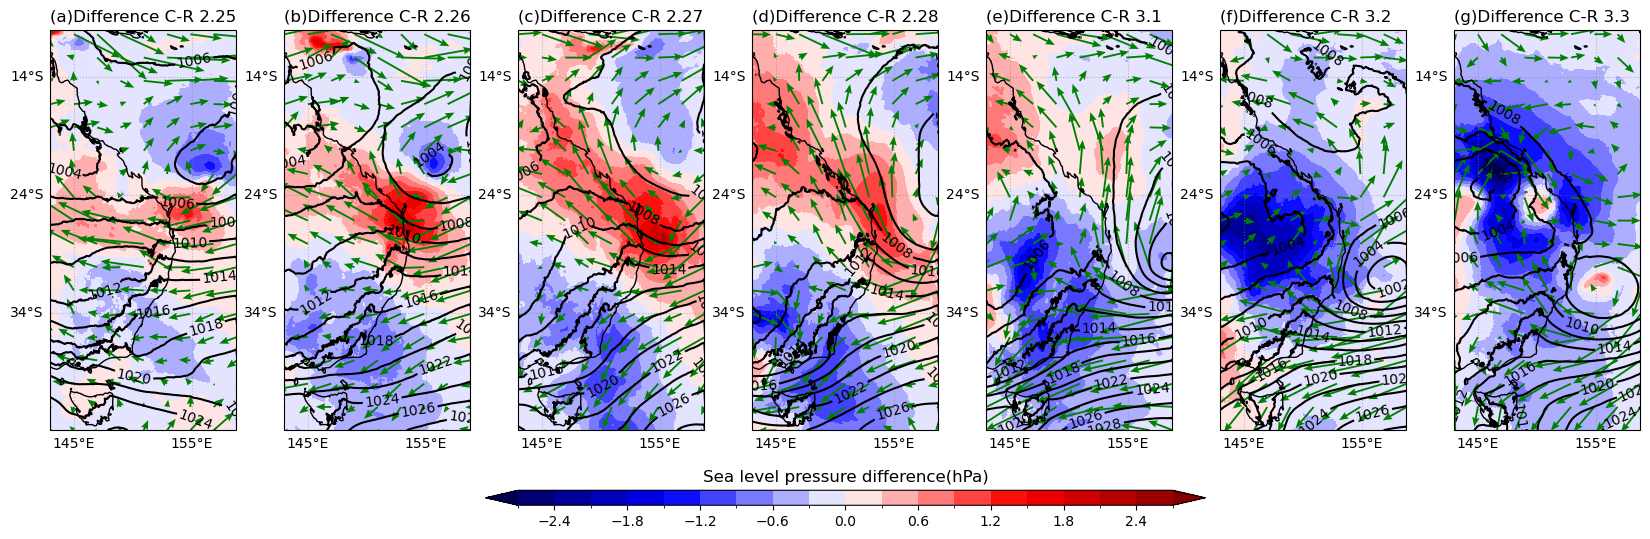

In [9]:
title = np.array(['(a)Difference C-R 2.25','(b)Difference C-R 2.26','(c)Difference C-R 2.27','(d)Difference C-R 2.28','(e)Difference C-R 3.1','(f)Difference C-R 3.2','(g)Difference C-R 3.3'])

seismic = mpl.colormaps['seismic_r'].resampled(20)
bounds = np.arange(-2.7,3,0.3)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=seismic.N, extend='both')

plt.figure(figsize=(18, 5))
for i in range(7):
    ax = plt.axes([0.04+i*0.13, 0.9, 0.12, 0.8], projection=ccrs.PlateCarree())
    ax.set_extent([143, 158.8, -44, -10], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle=':', xlocs=np.arange(135, 159, 10), ylocs=np.arange(-44, -10, 10))
    gl.right_labels = False
    gl.top_labels = False
    ax.coastlines()
    ax.set_title('{}'.format(title[i]), loc='left')
    cf1 = ax.contourf(lonm, latm, mslp_cont_minus_exp[i], bounds, norm=norm, transform=ccrs.PlateCarree(), cmap=seismic.reversed(), add_colorbar=False, extend='both')
    cf2 = ax.contour(lonm, latm, control_mslp[i], levels=np.arange(1000,1030,2), colors='k', transform=ccrs.PlateCarree(), add_colorbar=False, extend='both')
    ax.clabel(cf2, inline=True)
    vf = ax.quiver(lon[::100], lat[::100], control_u850[i].values[::100, ::100], control_v850[i].values[::100, ::100],
                   transform=ccrs.PlateCarree(), color='green', scale=5, width=0.01, headwidth=4, headlength=5)

position = plt.axes([0.29, 0.75, 0.4, 0.03])
cbar = plt.colorbar(cf1, cax=position, orientation='horizontal')
cbar.ax.set_title(r'Sea level pressure difference(hPa)')

plt.show()